## The Stationarity vs Memory Dilemma

대부분의 금융 시계열 분석은 두가지 상황에서 딜레마에 빠진다
1. Box-Jenkins : log difference 데이터는 정상성을 가지지만, market memory를 가지지 않는다
2. Engle-Granger : log price 계열은 market memory를 가진다. 하지만 비정상성을 얻게 된다. Cointegration은 비정상성 시계열에서 회귀모형을 작동 가능하게 하지만 매우 제한적인 상황에서 발견되며, Cointegration의 안정성도 신뢰가 좋다고는 볼 수 없다

Long memory model은 ADF 검정 결과를 지키는 최소한의 차분계수($d$)통해 market memory와 stationarity를 모두 포함하도록 해 준다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf

start_date = '2000-01-01'
end_date = '2024-04-17'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


#### Fractionally differentiated Features

실수값인 feature $\{X_t\}$에 적용한 backshift 연산자 $B$를 가정해 보자. 여기서 $k \geq 0$인 모든 정수에 대해 $B^kX_t = X_{t-k}$이다. 양의 정수 $n$에 $(x+y)^n = \sum_{k=0}^n {n \choose k} x^k y^{n-k} = \sum_{k=0}^n {n \choose k}x^{n-k}k^k$라는 것에 주목하자. 실수 $d$에서 $(1+x)^d = \sum_{k=0}^\infty {d \choose k} x^k$ 즉, 이항 계열이다. Fractionally differentiated model에서 지수 $d$는 실수값이 가능하고, 다음 형식의 이항 계열 확장을 따른다

$$\begin{matrix}
(1-B)^d = \sum_{k=0}^\infty {d \choose k}(-B)^k &=& \sum_{k=0}^\infty \frac{\prod_{i=0}^{k-1}(d-i)}{k!} \\
       &=& \sum_{k=0}^\infty (-B)^k \prod_{i=0}^{k-1}\frac{d-i}{k-i} \\
       &=& 1 - dB + \frac{d(d-1)}{2!}B^2 - \frac{d(d-1)(d-2)}{3!}B^3 + \cdots
\end{matrix}$$

#### Long Memory

양의 실수 $d$가 기억을 유지하는 법을 알아보도록 하자. 아래의 산술 계열은 내적으로 이뤄져 있다

$$\tilde X_t = \sum_{k=0}^\infty \omega_k X_{t-k}$$

여기서 가중값 $\omega$는

$$\omega = \Big\{
1, -d, \frac{d(d-1)}{2!}, -\frac{d(d-1)(d-2)}{3!}, \cdots, (-1)^k \prod_{i=0}^{k-1} \frac{d-i}{k!}, \cdots
\Big\}$$

그리고 값 $X$는

$$X = \{X_t, X_{t-1}, X_{t-2}, X_{t-3}, \dots, X_{t-k}, \dots\}$$

이다.

$d$가 양의 정수일 때 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>d$이고, 이 지점을 넘어선 market memory는 소멸된다. 예를들어, $d=1$일 경우 수익률을 계산하기 위해 사용하는 차분계수이다. 여기서 $\prod_{i=0}^{k-1} \frac{d-i}{k!} = 0, \forall k>1$이고 $\omega = \{1,-1,0,0,\cdots \}$이다

가중값 $\omega$의 sequence를 살펴보면 $\omega_0 = 1$이고, $k = 0, \dots, \infty$에 대해서 가중값은 반복적으로 다음과 같이 생성된다.

$$\omega_k = -\omega_{k-1}\frac{d-k+1}{k}$$

#### Stationarity with Maximum Memory Preservation

Time series $\{X_t\}_{t=1, \dots, T}$를 고려해 보자. Fixing-width window fractional difference 방법을 이 계열에 적용하면 Fractional differentiated Series $\{\tilde X_t\}_{t=l^*, \dots, T}$이 정상성을 가지도록 하는 최소의 차분계수 $d^*$를 구할 수 있다. 이 계수는 정상성을 얻기 위해 없애야 하는 기억의 양을 정량화 한다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 이미 stationary하다면 $d^*=0$이다

$\{\tilde X_t\}_{t=l^*, \dots, T}$가 unit root을 가지고 있다면 $d^* <1$이다. $\{\tilde X_t\}_{t=l^*, \dots, T}$가 폭발적 행태를 보인다면 $d^* >1$이다. 이 중 $0<d^* <1$인 경우는 원시계열이 약간의 비정상성을 가지는 경우로, 이 경우 정상성을 위해 차분이 필요하지만, 1차 차분을 하게 되면 원시계열에 담겨 있는 market memory와 유의미한 신호를 제거하게 된다

In [2]:
def get_weights(d, size) :
    # thres > 0 유의미하지 않은 가중값을 제거
    w = [1.]
    for k in range(1, size) :
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def plot_weights(d_range, n_plots, size) :
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots) :
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index = range(w_.shape[0])[::-1], columns = [d])
        w = w.join(w_, how = 'outer')
    ax = w.plot()
    plt.grid(False)
    ax.legend(loc = 'upper right')
    plt.show()
    return None

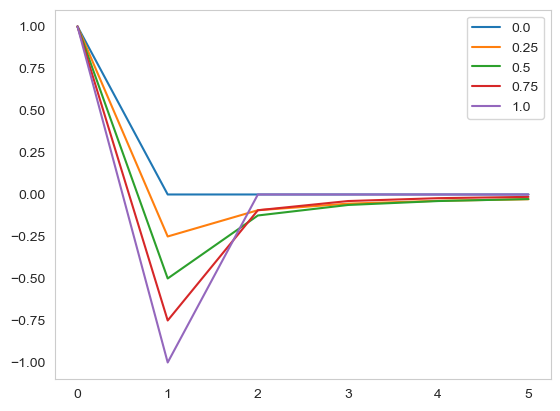

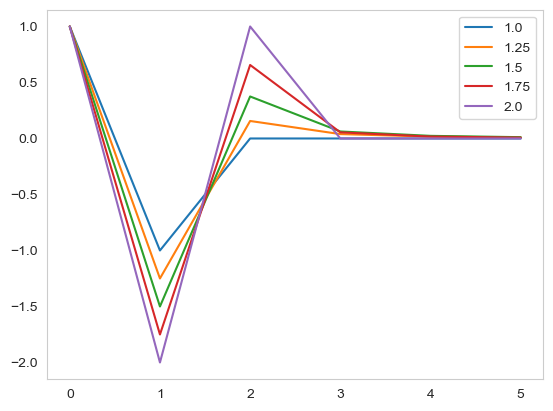

In [3]:
if __name__ == '__main__' :
    plot_weights(d_range = [0, 1], n_plots = 5, size = 6)
    plot_weights(d_range = [1, 2], n_plots = 5, size = 6)

In [4]:
from FinancialMachineLearning.features.fracdiff import FractionalDifferentiatedFeatures

cols = ['adfStat','pVal','lags','nObs','95% conf', 'corr']
out = pd.DataFrame(columns = cols)
for d in np.linspace(0, 1, 21):
    try:
        df1 = data[['Adj Close']]
        df2 = FractionalDifferentiatedFeatures.fracDiff(df1, d = d, thres = 1e-5)
        corr = np.corrcoef(df1.loc[df2.index,'Adj Close'], df2['Adj Close'])[0,1]
        df2 = sm.tsa.stattools.adfuller(df2['Adj Close'], maxlag = 1, regression = 'c', autolag = None)
        out.loc[round(d, 2)] = list(df2[:4]) + [df2[4]['5%']] + [corr]
    except Exception as e:
        print(f'd: {round(d, 2)}, error: {e}')
        continue

d: 0.05, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.1, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.15, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.2, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors
d: 0.25, error: maxlag must be less than (nobs/2 - 1 - ntrend) where n trend is the number of included deterministic regressors


In [5]:
out

,adfStat,pVal,lags,nObs,95% conf,corr
0.00,0.996045,9.942240e-01,1.0,6107.0,-2.862013,1.000000
0.30,-1.494795,5.360847e-01,1.0,5.0,-3.929280,0.944662
0.35,-1.951754,3.081195e-01,1.0,8.0,-3.367187,0.929395
0.40,-2.291423,1.747490e-01,1.0,12.0,-3.154972,0.897669
0.45,-3.173802,2.155211e-02,1.0,19.0,-3.031227,0.809597
0.50,-3.226918,1.847848e-02,1.0,31.0,-2.960525,0.527159
0.55,-3.855924,2.384258e-03,1.0,50.0,-2.921360,0.478931
0.60,-4.434436,2.578372e-04,1.0,81.0,-2.897943,0.495012
0.65,-4.699271,8.441846e-05,1.0,133.0,-2.883528,0.461179
0.70,-6.629771,5.754116e-09,1.0,223.0,-2.874590,0.405377


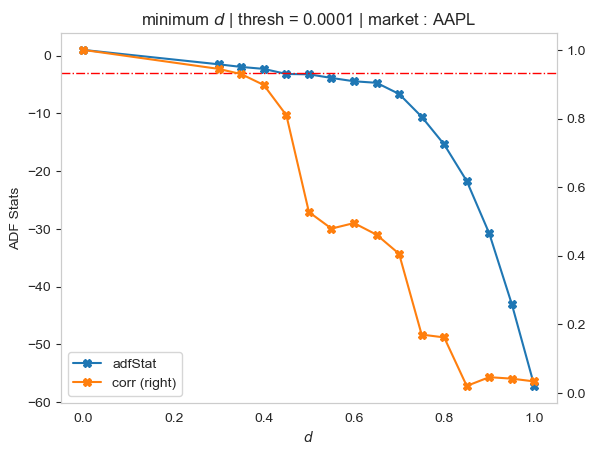

In [6]:
f,ax = plt.subplots()
out[['adfStat', 'corr']].plot(ax = ax, marker = 'X', secondary_y = 'corr')
ax.axhline(out['95% conf'].mean(), lw = 1, color = 'r', ls = '-.')
ax.set_title(r'minimum $d$ | thresh = 0.0001 | market : AAPL')
ax.set_xlabel(r'$d$')
ax.grid(False)
ax.set_ylabel('ADF Stats')
plt.show()

In [7]:
frac_close = FractionalDifferentiatedFeatures.fracDiff(data[['Adj Close']], 0.45)

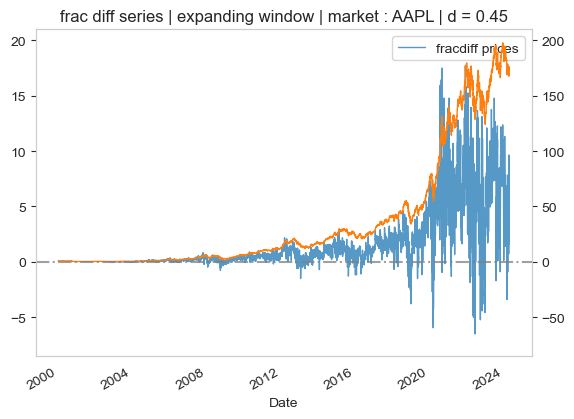

In [8]:
frac_close['Adj Close'].plot(alpha = 0.75, lw = 1)
plt.grid(False)
plt.legend(['fracdiff prices'], loc = 'upper left')
plt.ylim([-8.5, 21])
data['Adj Close'].plot(secondary_y = True, lw = 1, alpha = 1)
plt.ylim([-85, 210])
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.grid(False)
plt.title('frac diff series | expanding window | market : AAPL | d = 0.45')
plt.show()

In [9]:
frac_close_ffd = FractionalDifferentiatedFeatures.fracDiff_FFD(data[['Adj Close']], 0.45)

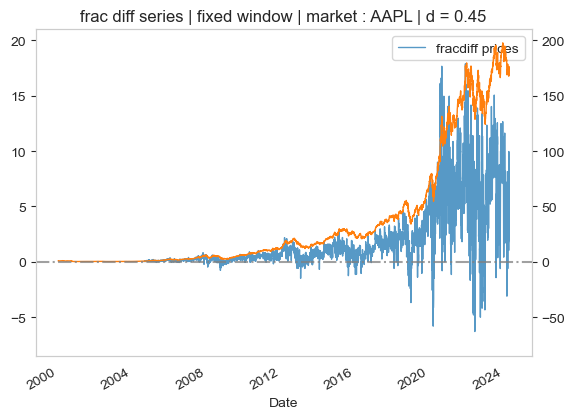

In [10]:
frac_close_ffd['Adj Close'].plot(alpha = 0.75, lw = 1)
plt.ylim([-8.5, 21])
plt.grid(False)
plt.legend(['fracdiff prices'], loc = 'upper left')
data['Adj Close'].plot(secondary_y = True, lw = 1, alpha = 1)
plt.grid(False)
plt.ylim([-85, 210])
plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
plt.title('frac diff series | fixed window | market : AAPL | d = 0.45')
plt.show()

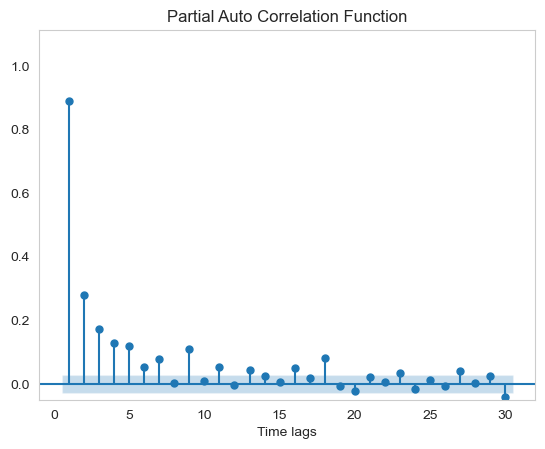

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(
    frac_close_ffd['Adj Close'], 
    auto_ylims = True, 
    lags = range(1, 31)
)
plt.grid(False)
plt.xlabel('Time lags')
plt.title('Partial Auto Correlation Function')
plt.show()

In [12]:
import warnings
warnings.filterwarnings('ignore')

arima = sm.tsa.ARIMA(
    frac_close_ffd['Adj Close'], 
    order = (18,0,0), 
    trend = 'c'
).fit(method = 'innovations_mle')

In [13]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4948
Model:                ARIMA(18, 0, 0)   Log Likelihood               -8131.181
Date:                Mon, 06 May 2024   AIC                          16302.362
Time:                        00:11:10   BIC                          16432.497
Sample:                             0   HQIC                         16347.997
                               - 4948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9724      0.989      1.994      0.046       0.034       3.911
ar.L1          0.5375      0.007     82.251      0.000       0.525       0.550
ar.L2          0.1066      0.007     14.669      0.0